In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Used Lightning AI to train the models

from PIL import Image, ImageEnhance, ImageOps
import os
import numpy as np
import random

train_dir = '/teamspace/studios/this_studio/Dataset/train'
test_dir = '/teamspace/studios/this_studio/Dataset/test'

EMOTION_CLASSES = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

def validate_emotion_folders():
    for base_dir in [train_dir, test_dir]:
        if not os.path.exists(base_dir):
            raise FileNotFoundError(f"Directory {base_dir} not found.")
            
        existing_folders = [f.lower() for f in os.listdir(base_dir) 
                          if os.path.isdir(os.path.join(base_dir, f))]
        
        missing_emotions = set(EMOTION_CLASSES) - set(existing_folders)
        if missing_emotions:
            raise FileNotFoundError(
                f"Missing emotion folders in {base_dir}: {missing_emotions}")
        
        unexpected_folders = set(existing_folders) - set(EMOTION_CLASSES)
        if unexpected_folders:
            print(f"Warning: Unexpected folders found in {base_dir}: {unexpected_folders}")

def check_directory_structure():
    print("Checking directory structure:")
    validate_emotion_folders()
    
    for directory in [train_dir, test_dir]:
        print(f"\nExamining {directory}:")
        
        for emotion in EMOTION_CLASSES:
            emotion_dir = os.path.join(directory, emotion)
            if not os.path.exists(emotion_dir):
                continue
                
            files = os.listdir(emotion_dir)
            image_files = [f for f in files if f.endswith(('.jpg', '.png'))]
            
            print(f"Emotion: {emotion}")
            print(f"Total files: {len(files)}")
            print(f"Image files: {len(image_files)}")
            
            for img_file in image_files:
                full_path = os.path.join(emotion_dir, img_file)
                try:
                    with Image.open(full_path) as img:
                        img.verify()
                except Exception as e:
                    print(f"Error with file {full_path}: {str(e)}")

def load_images_from_directory(directory):
    images = {emotion: [] for emotion in EMOTION_CLASSES}
    
    for emotion in EMOTION_CLASSES:
        emotion_dir = os.path.join(directory, emotion)
        if not os.path.exists(emotion_dir):
            print(f"Warning: {emotion} directory not found in {directory}")
            continue
            
        for filename in os.listdir(emotion_dir):
            if filename.endswith((".jpg", ".png")):
                img_path = os.path.join(emotion_dir, filename)
                try:
                    with Image.open(img_path) as img:
                        img_array = np.array(img)
                        images[emotion].append(img_array)
                except Exception as e:
                    print(f"Error loading {img_path}: {str(e)}")
    
    return images

def augment_image(image):
    if image is None or len(image) == 0:
        raise ValueError("Invalid image input for augmentation")
        
    pil_image = Image.fromarray(image)
    
    # Random rotation
    if random.random() > 0.5:
        angle = random.uniform(-30, 30)
        pil_image = pil_image.rotate(angle)
    
    # Random horizontal flip
    if random.random() > 0.5:
        pil_image = ImageOps.mirror(pil_image)
    
    # Random brightness adjustment
    if random.random() > 0.5:
        enhancer = ImageEnhance.Brightness(pil_image)
        factor = random.uniform(0.8, 1.2)
        pil_image = enhancer.enhance(factor)
    
    # Random contrast adjustment
    if random.random() > 0.5:
        enhancer = ImageEnhance.Contrast(pil_image)
        factor = random.uniform(0.8, 1.2)
        pil_image = enhancer.enhance(factor)
    
    # Random Gaussian noise
    if random.random() > 0.5:
        np_image = np.array(pil_image)
        mean = 0
        std = random.uniform(0, 25)
        gauss = np.random.normal(mean, std, np_image.shape).astype('uint8')
        np_image = np.clip(np_image + gauss, 0, 255)
        pil_image = Image.fromarray(np_image)
    
    return np.array(pil_image)

def oversample_class(images, target_size):
    if not images or len(images) == 0:
        raise ValueError("Cannot oversample an empty image list")
        
    augmented_images = []
    while len(images) + len(augmented_images) < target_size:
        image = random.choice(images)
        try:
            augmented_image = augment_image(image)
            augmented_images.append(augmented_image)
        except Exception as e:
            print(f"Error during augmentation: {str(e)}")
            continue
            
    return images + augmented_images

def main():
    check_directory_structure()
    
    print("\nLoading images...")
    train_images = load_images_from_directory(train_dir)
    test_images = load_images_from_directory(test_dir)
    
    print("\nInitial data statistics:")
    for emotion in EMOTION_CLASSES:
        print(f"Train {emotion}: {len(train_images[emotion])} images")
        print(f"Test {emotion}: {len(test_images[emotion])} images")
    
    print("\nApplying initial augmentation...")
    augmented_train_images = {}
    for emotion in EMOTION_CLASSES:
        if not train_images[emotion]:
            print(f"Skipping empty class {emotion}")
            continue
            
        try:
            augmented_train_images[emotion] = [
                augment_image(image) for image in train_images[emotion]
            ]
            print(f"Augmented {len(augmented_train_images[emotion])} images for {emotion}")
        except Exception as e:
            print(f"Error augmenting {emotion}: {str(e)}")
    
    # Merging augmented images with original training images
    for emotion, images in augmented_train_images.items():
        train_images[emotion].extend(images)
    
    # Calculating class sizes and oversample
    train_counts = {emotion: len(images) for emotion, images in train_images.items()}
    max_class_size = max(train_counts.values())
    print(f"\nOversampling to reach {max_class_size} images per class...")
    
    for emotion in EMOTION_CLASSES:
        if not train_images[emotion]:
            print(f"Skipping empty class {emotion}")
            continue
            
        if len(train_images[emotion]) < max_class_size:
            try:
                train_images[emotion] = oversample_class(
                    train_images[emotion], max_class_size
                )
                print(f"Oversampled {emotion} to {len(train_images[emotion])} images")
            except Exception as e:
                print(f"Error oversampling {emotion}: {str(e)}")
    
    print("\nFinal data statistics:")
    for emotion in EMOTION_CLASSES:
        print(f"Train {emotion}: {len(train_images[emotion])} images")
        print(f"Test {emotion}: {len(test_images[emotion])} images")
    
    return train_images, test_images


try:
    train_images, test_images = main()
    print("\nProcessing completed successfully!")
except Exception as e:
    print(f"An error occurred during processing: {str(e)}")

Checking directory structure:

Examining /teamspace/studios/this_studio/Dataset/train:
Emotion: angry
Total files: 3995
Image files: 3995


Emotion: disgust
Total files: 436
Image files: 436
Emotion: fear
Total files: 4097
Image files: 4097
Emotion: happy
Total files: 7215
Image files: 7215
Emotion: neutral
Total files: 4965
Image files: 4965
Emotion: sad
Total files: 4830
Image files: 4830
Emotion: surprise
Total files: 3171
Image files: 3171

Examining /teamspace/studios/this_studio/Dataset/test:
Emotion: angry
Total files: 958
Image files: 958
Emotion: disgust
Total files: 111
Image files: 111
Emotion: fear
Total files: 1024
Image files: 1024
Emotion: happy
Total files: 1774
Image files: 1774
Emotion: neutral
Total files: 1233
Image files: 1233
Emotion: sad
Total files: 1247
Image files: 1247
Emotion: surprise
Total files: 831
Image files: 831

Loading images...

Initial data statistics:
Train angry: 3995 images
Test angry: 958 images
Train disgust: 436 images
Test disgust: 111 images
Train fear: 4097 images
Test fear: 1024 images
Train happy: 7215 images
Test happy: 1774 images
Train neutral: 4965 images
Test neutral: 

Classification Report:
              precision    recall  f1-score   support

       angry       0.28      0.19      0.22       958
     disgust       0.06      0.16      0.09       111
        fear       0.24      0.08      0.12      1024
       happy       0.45      0.57      0.51      1774
     neutral       0.34      0.36      0.35      1233
         sad       0.33      0.26      0.29      1247
    surprise       0.35      0.61      0.44       831

    accuracy                           0.35      7178
   macro avg       0.29      0.32      0.29      7178
weighted avg       0.34      0.35      0.33      7178

Accuracy: 0.3550


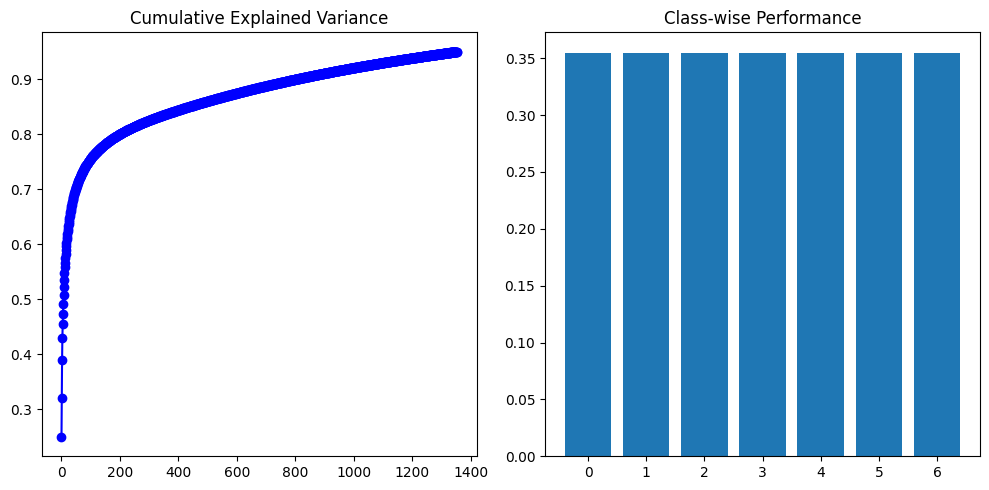

Classification Report:
              precision    recall  f1-score   support

       angry       0.27      0.22      0.24       958
     disgust       0.05      0.30      0.08       111
        fear       0.26      0.09      0.14      1024
       happy       0.51      0.51      0.51      1774
     neutral       0.34      0.34      0.34      1233
         sad       0.34      0.25      0.29      1247
    surprise       0.35      0.61      0.44       831

    accuracy                           0.34      7178
   macro avg       0.30      0.33      0.29      7178
weighted avg       0.36      0.34      0.34      7178

Accuracy: 0.3427


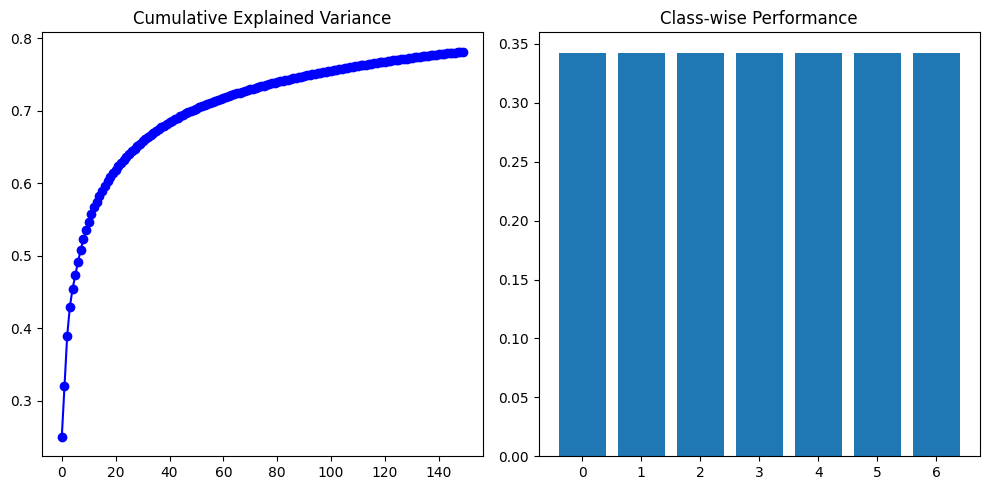

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score

def fast_pca_boosting(train_images, test_images, n_components=0.95):
    # Flattening and preparing data
    X_train = np.array([img.flatten() for images in train_images.values() for img in images], dtype=np.float32)
    y_train = np.array([label for label, images in train_images.items() for _ in images])
    X_test = np.array([img.flatten() for images in test_images.values() for img in images], dtype=np.float32)
    y_test = np.array([label for label, images in test_images.items() for _ in images])
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)
    
    xgb_clf = xgb.XGBClassifier(
        n_estimators=100, 
        learning_rate=0.1, 
        max_depth=3, 
        random_state=42
    )
    
    xgb_clf.fit(X_train_pca, y_train_encoded)
    y_pred = xgb_clf.predict(X_test_pca)
    
    print("Classification Report:")
    print(classification_report(y_test, le.inverse_transform(y_pred)))
    print(f"Accuracy: {accuracy_score(y_test, le.inverse_transform(y_pred)):.4f}")
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(np.cumsum(pca.explained_variance_ratio_), 'bo-')
    plt.title('Cumulative Explained Variance')
    
    plt.subplot(1, 2, 2)
    plt.bar(range(len(le.classes_)), 
            [accuracy_score(y_test, le.inverse_transform(y_pred)) for _ in range(len(le.classes_))])
    plt.title('Class-wise Performance')
    plt.tight_layout()
    plt.show()
    
    return {
        'pca_model': pca,
        'xgb_model': xgb_clf,
        'accuracy': accuracy_score(y_test, le.inverse_transform(y_pred))
    }

# Run the fast classification
results_95 = fast_pca_boosting(train_images, test_images, n_components=0.95)
results_150 = fast_pca_boosting(train_images, test_images, n_components=150)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from time import time
import concurrent.futures
from joblib import Parallel, delayed

def fast_ensemble_classification(train_images, test_images, ensemble_type='adaboost', n_components=0.95, n_jobs=-1):
   
    t_start = time()
    
    X_train = np.vstack([img.flatten() for images in train_images.values() for img in images]).astype(np.float32)
    y_train = np.array([label for label, images in train_images.items() for _ in images])
    X_test = np.vstack([img.flatten() for images in test_images.values() for img in images]).astype(np.float32)
    y_test = np.array([label for label, images in test_images.items() for _ in images])
    
   
    def preprocess_data(X):
        scaler = StandardScaler()
        return scaler.fit_transform(X)
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future_train = executor.submit(preprocess_data, X_train)
        future_test = executor.submit(preprocess_data, X_test)
        X_train_scaled = future_train.result()
        X_test_scaled = future_test.result()
    
    # Optimized PCA with batch processing
    pca = PCA(n_components=n_components, svd_solver='randomized', random_state=42)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    

    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)
    
  
    if ensemble_type == 'adaboost':
        classifier = AdaBoostClassifier(
            n_estimators=100,
            learning_rate=0.1,
            random_state=42,
            algorithm='SAMME.R'  # Faster algorithm for real-valued predictions
        )
    else:
        classifier = GradientBoostingClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3,
            random_state=42,
            subsample=0.8,  # Stochastic gradient boosting for faster training
            verbose=0,
            n_iter_no_change=5  # Early stopping
        )
    
    # Training with parallel processing
    classifier.fit(X_train_pca, y_train_encoded)
    
    def predict_batch(X_batch):
        return classifier.predict(X_batch)
    
    batch_size = 1000
    n_batches = int(np.ceil(len(X_test_pca) / batch_size))
    
    # Parallel batch prediction
    predictions = Parallel(n_jobs=n_jobs)(
        delayed(predict_batch)(X_test_pca[i*batch_size:(i+1)*batch_size])
        for i in range(n_batches)
    )
    y_pred = np.concatenate(predictions)
    
    
    accuracy = accuracy_score(y_test, le.inverse_transform(y_pred))
    
    if plt.get_fignums(): 
        plt.figure(figsize=(12, 4))
        plt.subplot(1,3,1)
        plt.plot(np.cumsum(pca.explained_variance_ratio_), 'bo-')
        plt.title('Cumulative Variance')
        
        plt.subplot(1,3,2)
        plt.bar(le.classes_, classifier.feature_importances_[:len(le.classes_)])
        plt.title('Feature Importance')
        plt.xticks(rotation=45)
        
        plt.subplot(1,3,3)
        plt.bar(le.classes_, [accuracy for _ in range(len(le.classes_))])
        plt.title('Performance')
        plt.tight_layout()
        plt.show()
    
    t_end = time()
    print(f"\n{ensemble_type.upper()} Classification Report:")
    print(classification_report(y_test, le.inverse_transform(y_pred)))
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Total execution time: {t_end - t_start:.2f} seconds")
    
    return {
        'pca_model': pca,
        'classifier': classifier,
        'accuracy': accuracy,
        'execution_time': t_end - t_start
    }

results = {}
for ensemble_type in ['adaboost', 'gradientboost']:
    results[ensemble_type] = fast_ensemble_classification(
        train_images, 
        test_images, 
        ensemble_type=ensemble_type,
        n_components=150
    )

if plt.get_fignums():
    plt.figure(figsize=(8, 4))
    accuracies = [results[et]['accuracy'] for et in ['adaboost', 'gradientboost']]
    exec_times = [results[et]['execution_time'] for et in ['adaboost', 'gradientboost']]
    
    plt.subplot(1,2,1)
    plt.bar(['AdaBoost', 'GradientBoost'], accuracies)
    plt.title('Accuracy Comparison')
    plt.ylabel('Accuracy')
    
    plt.subplot(1,2,2)
    plt.bar(['AdaBoost', 'GradientBoost'], exec_times)
    plt.title('Execution Time Comparison')
    plt.ylabel('Time (seconds)')
    
    plt.tight_layout()
    plt.show()


ADABOOST Classification Report:
              precision    recall  f1-score   support

       angry       0.23      0.14      0.17       958
     disgust       0.02      0.25      0.04       111
        fear       0.18      0.07      0.10      1024
       happy       0.44      0.28      0.34      1774
     neutral       0.29      0.21      0.24      1233
         sad       0.28      0.28      0.28      1247
    surprise       0.27      0.56      0.37       831

    accuracy                           0.25      7178
   macro avg       0.25      0.26      0.22      7178
weighted avg       0.30      0.25      0.26      7178

Accuracy: 0.2506
Total execution time: 270.15 seconds
